<a href="https://colab.research.google.com/github/nazmus007/transformers_test/blob/main/Sarcasm_detection_XLNet_ptacek_run2%2Bemoji.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Mon Sep  6 19:13:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cuda.empty_cache()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -qq transformers

     |████████████████████████████████| 2.9 MB 4.3 MB/s 
     |████████████████████████████████| 636 kB 89.6 MB/s 
     |████████████████████████████████| 56 kB 6.9 MB/s 
     |████████████████████████████████| 3.3 MB 60.9 MB/s 
     |████████████████████████████████| 895 kB 65.3 MB/s 


### Making the necessary imports

In [2]:
import transformers
from transformers import XLNetTokenizer, XLNetModel, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from collections import defaultdict
from textwrap import wrap
from pylab import rcParams

from torch import nn, optim



In [3]:
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset,RandomSampler,SequentialSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Data Preprocessing

In [5]:
df = pd.read_csv('./drive/MyDrive/datasets/cleaned_ptacek_wtweets_wnotebook.csv')
df.head()

,Unnamed: 0,index,Tweet_id,Tweet,Label
0,0,0,411348816583856129,peyton obviously cannot finish games he just t...,1
1,1,1,408111537011036160,well i would love to be sleeping right now but...,1
2,2,2,403282506230665217,my biggest executive decision today choosing b...,1
3,3,3,409720467662983168,the first quality opponent they played in 2 y...,1
4,4,4,403005765608554496,but do not you dare call it hate crimes libe...,1


In [8]:
!pip install demoji

     |████████████████████████████████| 42 kB 380 kB/s 


In [6]:
import demoji
def demoji_text(text):
  d= demoji.findall(text)
  return d

In [7]:
df['emoji_list'] = df['Tweet'].apply(demoji_text)

In [8]:
f= list(filter(None, df['emoji_list']))

In [9]:
print(f)

[{'👌': 'OK hand', '😏': 'smirking face'}, {'👍': 'thumbs up'}, {'😡': 'pouting face'}, {'😫': 'tired face', '🙈': 'see-no-evil monkey', '😍': 'smiling face with heart-eyes', '🔫': 'water pistol'}, {'😐': 'neutral face'}, {'😒': 'unamused face'}, {'👀': 'eyes', '😮': 'face with open mouth'}, {'😭': 'loudly crying face', '🔫': 'water pistol'}, {'👌': 'OK hand'}, {'😒': 'unamused face'}, {'👌': 'OK hand', '😳': 'flushed face'}, {'😣': 'persevering face'}, {'😒': 'unamused face'}, {'👌': 'OK hand'}, {'😒': 'unamused face'}, {'🙈': 'see-no-evil monkey'}, {'😒': 'unamused face'}, {'😊': 'smiling face with smiling eyes'}, {'👌': 'OK hand'}, {'😑': 'expressionless face'}, {'👍': 'thumbs up'}, {'🎉': 'party popper'}, {'😒': 'unamused face', '👏': 'clapping hands'}, {'😛': 'face with tongue'}, {'😒': 'unamused face'}, {'😻': 'smiling cat with heart-eyes'}, {'😑': 'expressionless face'}, {'😰': 'anxious face with sweat'}, {'😉': 'winking face'}, {'😳': 'flushed face'}, {'😭': 'loudly crying face'}, {'💁': 'person tipping hand'}, {'😤':

In [10]:
all_keys = set().union(*(d.keys() for d in f))

In [11]:
print(all_keys)

{'😀', '😏', '☺️', '🎾', '🍧', '💔', '📯', '😿', '😶', '🍔', '🇬🇧', '📖', '😊', '🌏', '🎸', '😥', '🍝', '🎌', '✋', '😳', '💅', '👆', '🔮', '🍬', '👈', '😍', '😕', '🚬', '🔥', '☃', '🔞', '👔', '🏊', '💝', '🐒', '🎈', '🌴', '🏃', '🍩', '👎', '🍤', '💩', '©', '🚴', '🐣', '👻', '🚼', '💊', '🌱', '🙆', '🙅', '👅', '🐤', '❗', '✖', '💰', '⚡', '💂', '⬅️', '💚', '💌', '🍕', '🎁', '👊', '😱', '🌌', '📚', '💞', '🍭', '⛄', '👳', '🎤', '📀', '💨', '😁', '😨', '💖', '🚗', '😇', '💧', '🇫🇷', '😎', '🌃', '〰', '💽', '🏂', '🆒', '🍦', '😩', '🌻', '💀', '⏰', '🍲', '🚢', '😅', '🍅', '😣', '👱', '😈', '🎆', '🍳', '🎎', '🍗', '💙', '🙊', '☹', '🍸', '💐', '🌅', '🎮', '🐬', '😯', '👃', '🍷', '🍖', '😒', '🍊', '🌸', '🍻', '🐽', '😰', '🆘', '🐛', '🍃', '😠', '🍰', '🎿', '🙌', '😪', '☠', '☀️', '▶', '👀', '🍺', '😢', '👫', '🙈', '🚔', '🎊', '😑', '🎹', '◽', '☮', '✊', '👩', '🚨', '💕', '⭐', '❌', '👬', '😭', '🌲', '🌀', '🍹', '💆', '👌', '▪', '💎', '➡️', '😓', '☺', '🍓', '💋', '🐾', '🍛', '👠', '🌆', '™', '📓', '🙀', '🚀', '🙋', '💢', '🎼', '🍍', '✴', '😽', '😝', '👶', '😫', '😐', '❄', '💻', '👙', '✔️', '😵', '😬', '😮', '🍉', '👾', '🏄', '😚', '🎨', '💛', '😜', '🐥', '🔄', '🌠', '❄

In [12]:
len(all_keys)

368

In [13]:
df= df.drop(['Unnamed: 0','index','Tweet_id'],axis=1)

In [6]:
import re
emoji_1 = re.compile('[\\u203C-\\u3299\\U0001F000-\\U0001F644]')

In [7]:
emoji_list= list(filter(emoji_1.match, df['Tweet']))

In [8]:
emo_found= ' '.join(emoji for emoji in emoji_list)

In [11]:
!pip install emoji

     |████████████████████████████████| 168 kB 9.4 MB/s 
  Created wheel for emoji: filename=emoji-1.6.0-py3-none-any.whl size=168256 sha256=504e5c8294fa46cf1711f586e8b120a24d0a21b8f3f354b76b4893891e2df2d3
  Stored in directory: /root/.cache/pip/wheels/f7/d7/74/c720aaf345a042b0c2d74361873258c5e8649b7f11b2ccce49
Successfully built emoji


In [9]:
from emoji import UNICODE_EMOJI

def get_emoji_set(text):
    return {letter for letter in text if letter in UNICODE_EMOJI['en'] }

In [10]:
c = get_emoji_set(emo_found)

In [11]:
print(c)

{'🏥', '😝', '🐶', '🎅', '🍃', '💝', '🍊', '👫', '😩', '💚', '🙊', '❄', '🍻', '😋', '☕', '😍', '🎈', '😛', '💕', '😒', '😕', '🌏', '🎧', '😇', '🌞', '⛄', '💊', '🐉', '💗', '🎁', '🙉', '💯', '💦', '😙', '😱', '💎', '👌', '🐒', '🎀', '⭐', '💣', '☺', '😊', '🏈', '😏', '👼', '😆', '😂', '🌍', '📱', '🎄', '🎎', '😳', '♥', '😔', '🎶', '🍀', '🙈', '☹', '🐾', '✨', '🍩', '❤', '😘', '▶', '😢', '👑', '🐸'}


In [22]:
len(c)

68

In [18]:
!pip install emoji

     |████████████████████████████████| 168 kB 4.3 MB/s 
  Created wheel for emoji: filename=emoji-1.6.0-py3-none-any.whl size=168256 sha256=b519afb0f09544193ab8b4d94c255ad3b8d442616e55a03d6e5e758f912377c5
  Stored in directory: /root/.cache/pip/wheels/f7/d7/74/c720aaf345a042b0c2d74361873258c5e8649b7f11b2ccce49
Successfully built emoji


In [14]:
import emoji
def extract_emojis(s):
    return ''.join((' '+c+' ') if c in emoji.UNICODE_EMOJI['en'] else c for c in s)

In [15]:
df['Tweet'] = df['Tweet'].apply(extract_emojis)

In [16]:
df.columns = df.columns.str.lstrip()

In [ ]:
from sklearn.utils import shuffle
df = shuffle(df)
df.head(20)

,Tweet,Label
55286,tomorrow night pink in december hosted by satc...,0
45858,atheist billboard ads rejected in vancouver s...,0
28908,and this get a life sydq you so swt and i syd ...,0
27225,too easy to see me eh with nuri estatika pic —,0
5436,laugh out loud that ohio state wr that think t...,1
63133,decided to wait until next year will probabl...,0
61946,walaupon awak selalu buat hati saya sakit tapi...,0
30843,canada moves to cap domestic wireless roaming ...,0
44233,two 1s in less than six months how it feels like,0
10930,“ you like tanisha and armaan ” yes i love th...,1


In [ ]:
import re
def clean_text(text):
    text = re.sub(r"@[A-Za-z0-9]+", ' ', text)
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    text = re.sub(r"[^a-zA-z.!?'0-9]", ' ', text)
    text = re.sub('\t', ' ',  text)
    text = re.sub(r" +", ' ', text)
    text = re.sub(r'[^\w\s]',' ', text)
    return text

In [ ]:
df['Tweet'] = df['Tweet'].apply(clean_text)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


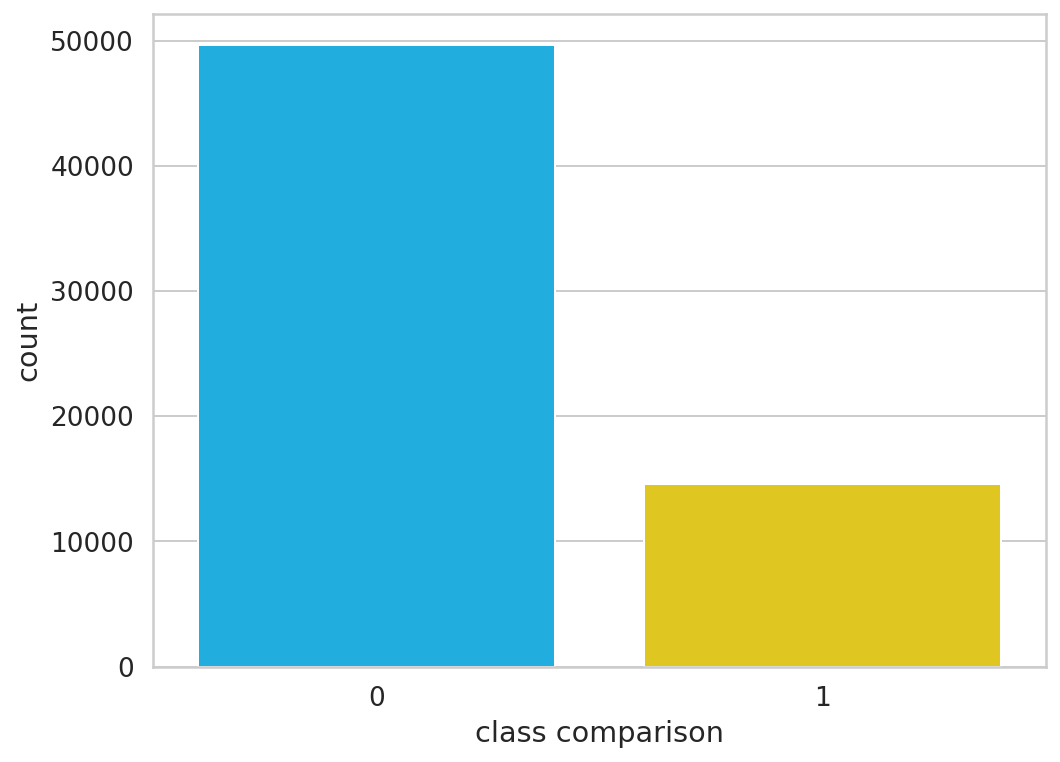

In [22]:
rcParams['figure.figsize'] = 8, 6
sns.countplot(df.Label)
plt.xlabel('class comparison');

In [17]:
df['Label'].value_counts()

0    49654
1    14580
Name: Label, dtype: int64

In [18]:
class_names = ['1', '0']

In [25]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 4.1 MB/s 


### Playing with XLNetTokenizer

In [19]:
from transformers import XLNetTokenizer, XLNetModel
PRE_TRAINED_MODEL_NAME = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokenizer.add_tokens(['😀', '😏', '☺️', '🎾', '🍧', '💔', '📯', '😿', '😶', '🍔', '🇬🇧', '📖', '😊', '🌏', '🎸', '😥', '🍝', '🎌', '✋', '😳', '💅', '👆', '🔮', '🍬', '👈', '😍', '😕', '🚬', '🔥', '☃', '🔞', '👔', '🏊', '💝', '🐒', '🎈', '🌴', '🏃', '🍩', '👎', '🍤', '💩', '©', '🚴', '🐣', '👻', '🚼', '💊', '🌱', '🙆', '🙅', '👅', '🐤', '❗', '✖', '💰', '⚡', '💂', '⬅️', '💚', '💌', '🍕', '🎁', '👊', '😱', '🌌', '📚', '💞', '🍭', '⛄', '👳', '🎤', '📀', '💨', '😁', '😨', '💖', '🚗', '😇', '💧', '🇫🇷', '😎', '🌃', '〰', '💽', '🏂', '🆒', '🍦', '😩', '🌻', '💀', '⏰', '🍲', '🚢', '😅', '🍅', '😣', '👱', '😈', '🎆', '🍳', '🎎', '🍗', '💙', '🙊', '☹', '🍸', '💐', '🌅', '🎮', '🐬', '😯', '👃', '🍷', '🍖', '😒', '🍊', '🌸', '🍻', '🐽', '😰', '🆘', '🐛', '🍃', '😠', '🍰', '🎿', '🙌', '😪', '☠', '☀️', '▶', '👀', '🍺', '😢', '👫', '🙈', '🚔', '🎊', '😑', '🎹', '◽', '☮', '✊', '👩', '🚨', '💕', '⭐', '❌', '👬', '😭', '🌲', '🌀', '🍹', '💆', '👌', '▪', '💎', '➡️', '😓', '☺', '🍓', '💋', '🐾', '🍛', '👠', '🌆', '™', '📓', '🙀', '🚀', '🙋', '💢', '🎼', '🍍', '✴', '😽', '😝', '👶', '😫', '😐', '❄', '💻', '👙', '✔️', '😵', '😬', '😮', '🍉', '👾', '🏄', '😚', '🎨', '💛', '😜', '🐥', '🔄', '🌠', '❄️', '👋', '😦', '🔆', '💯', '🌞', '😌', '💁', '🎉', '📺', '♦', '🕑', '🌎', '🎶', '👏', '😃', '🐇', '🍏', '🇩🇪', '☕', '😴', '🎵', '🌍', '🙉', '👂', '😷', '🐶', '🕥', '👯', '🌙', '🕐', '😙', '🎀', '💸', '😆', '🔫', '♏', '😉', '👭', '🐷', '💘', '👿', '♥', '☁️', '🎓', '😂', '⁉️', '😟', '💟', '💜', '😤', '🌊', '🌾', '🐴', '🍨', '🏡', '🐰', '😲', '💳', '🚶', '🍁', '😡', '🐳', '🔪', '🍠', '🌁', '😻', '🔯', '🔅', '🍀', '🎻', '🍵', '🐠', '👉', '☀', '👪', '✌', '👜', '💥', '😹', '👣', '🍈', '🇺🇸', '📨', '🇮🇹', '😗', '🌚', '💵', '🙍', '🎄', '🐉', '◾', '🌂', '💍', '⛪', '🎧', '❤️', '®', '❤', '👑', '💣', '🍋', '🎺', '📑', '🚺', '😘', '✌️', '🚫', '🌽', '💤', '🎥', '✏', '💪', '🏰', '😞', '✖️', '👹', '📣', '😺', '😄', '👰', '☔', '🎅', '😔', '☂', '💼', '🚓', '🍫', '👄', '💄', '👐', '💗', '🌵', '🐟', '💃', '🙏', '✨', '☝️', '☁', '🏈', '🍪', '⛅', '💉', '🐭', '⚽', '😛', '🍟', '💏', '😋', '📄', '🏥', '🐼', '♥️', '😧', '💦', '🎷', '🎂', '📱', '🚙', '👼', '🍆', '✈', '👸', '🎭', '🐸', '👍', '✈️', '😖', '🎋', '🐧'])
print(tokenizer)

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

PreTrainedTokenizer(name_or_path='xlnet-base-cased', vocab_size=32000, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='left', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '<sep>', 'pad_token': '<pad>', 'cls_token': '<cls>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True), 'additional_special_tokens': ['<eop>', '<eod>']})


In [20]:
input_txt = "the roads look really bad to me 😏 i think we need another day without school 👌"


In [21]:
encodings = tokenizer.encode_plus(input_txt, add_special_tokens=True, max_length=32, return_tensors='pt', return_token_type_ids=False, return_attention_mask=True, padding=True)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2228: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


In [22]:
encodings.keys()

dict_keys(['input_ids', 'attention_mask'])

In [23]:
print('input_ids : ',encodings['input_ids'])

input_ids :  tensor([[   18,  4378,   338,   343,   948,    22,   110, 32001,    17,   150,
           232,    80,   214,   245,   191,   286,   297, 32155,     4,     3]])


In [24]:
tokenizer.convert_ids_to_tokens(encodings['input_ids'][0])

['▁the',
 '▁roads',
 '▁look',
 '▁really',
 '▁bad',
 '▁to',
 '▁me',
 '😏',
 '▁',
 'i',
 '▁think',
 '▁we',
 '▁need',
 '▁another',
 '▁day',
 '▁without',
 '▁school',
 '👌',
 '<sep>',
 '<cls>']

In [25]:
type(encodings['attention_mask'])

torch.Tensor

In [26]:
tokens = tokenizer.tokenize(input_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {input_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: the roads look really bad to me 😏 i think we need another day without school 👌
   Tokens: ['▁the', '▁roads', '▁look', '▁really', '▁bad', '▁to', '▁me', '😏', '▁', 'i', '▁think', '▁we', '▁need', '▁another', '▁day', '▁without', '▁school', '👌']
Token IDs: [18, 4378, 338, 343, 948, 22, 110, 32001, 17, 150, 232, 80, 214, 245, 191, 286, 297, 32155]


In [27]:
attention_mask = pad_sequences(encodings['attention_mask'], maxlen=512, dtype=torch.Tensor ,truncating="post",padding="post")

In [28]:
attention_mask = attention_mask.astype(dtype = 'int64')
attention_mask = torch.tensor(attention_mask) 
attention_mask.flatten()

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [29]:
encodings['input_ids']

tensor([[   18,  4378,   338,   343,   948,    22,   110, 32001,    17,   150,
           232,    80,   214,   245,   191,   286,   297, 32155,     4,     3]])

### Checking the distribution of token lengths

In [30]:
token_lens = []

for txt in df['Tweet']:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


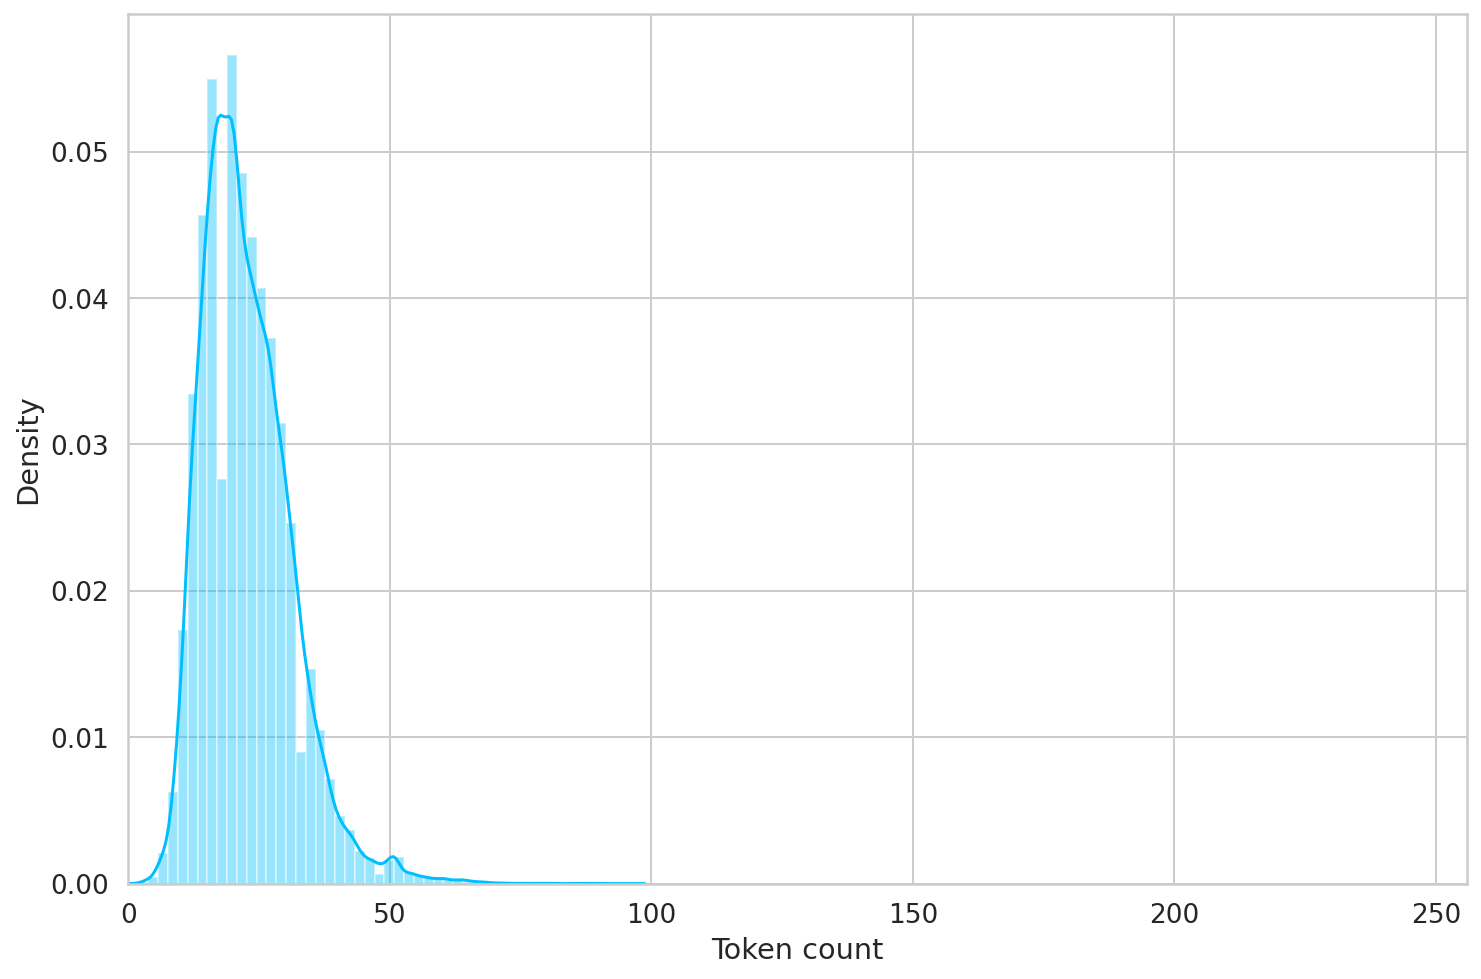

In [31]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [32]:
MAX_LEN = 128

### Custom Dataset class

In [33]:
class sarcasmDataset(Dataset):

    def __init__(self, tweets, targets, tokenizer, max_len):
        self.tweets = tweets
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.tweets)
    
    def __getitem__(self, item):
        Tweet = str(self.tweets[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
        Tweet,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=False,
        return_attention_mask=True,
        return_tensors='pt',
        )

        input_ids = pad_sequences(encoding['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        input_ids = input_ids.astype(dtype = 'int64')
        input_ids = torch.tensor(input_ids) 

        attention_mask = pad_sequences(encoding['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        attention_mask = attention_mask.astype(dtype = 'int64')
        attention_mask = torch.tensor(attention_mask)       

        return {
        'tweets': Tweet,
        'input_ids': input_ids,
        'attention_mask': attention_mask.flatten(),
        'targets': torch.tensor(target, dtype=torch.long)
        }

In [34]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=101)
df_val, df_test = train_test_split(df_test, test_size=0.3, random_state=101)

In [35]:
df_train.shape, df_val.shape, df_test.shape

((51387, 3), (8992, 3), (3855, 3))

### Custom Dataloader

In [36]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = sarcasmDataset(
    tweets=df.Tweet.to_numpy(),
    targets=df.Label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [37]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

### Loading the Pre-trained XLNet model for sequence classification from huggingface transformers

In [38]:
from transformers import XLNetForSequenceClassification
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels = 2)
model.resize_token_embeddings(len(tokenizer))
print(len(tokenizer))
model.to(device)

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

32368


XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32368, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [ ]:
model

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32068, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

### Setting Hyperparameters

In [39]:
EPOCHS = 4

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
                                {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay':0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5, eps= 1e-8)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

### Sanity check with one batch

In [40]:
data = next(iter(val_data_loader))
data.keys()

dict_keys(['tweets', 'input_ids', 'attention_mask', 'targets'])

In [42]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
targets = data['targets'].to(device)
print(input_ids.reshape(32,-1).shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 128])
torch.Size([32, 128])


In [43]:
input_ids[0]

tensor([[   18, 16103,  6609,    17,   694,    17,    23,   553, 12676,   249,
          2254, 15981,   153,   116,   369, 11005,    93,    17,  1979,   378,
            18, 16103,  1647,     4,     3,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [ ]:
outputs = model(input_ids.reshape(32,-1), token_type_ids=None, attention_mask=attention_mask, labels=targets)
#outputs

RuntimeError: ignored

In [ ]:
type(outputs[0])

torch.Tensor

### Defining the training step function

In [44]:
from sklearn import metrics
def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    acc = 0
    counter = 0
  
    for d in data_loader:
        input_ids = d["input_ids"].reshape(-1,128).to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
        loss = outputs[0]
        logits = outputs[1]

        # preds = preds.cpu().detach().numpy()
        _, prediction = torch.max(outputs[1], dim=1)
        targets = targets.cpu().detach().numpy()
        prediction = prediction.cpu().detach().numpy()
        accuracy = metrics.accuracy_score(targets, prediction)

        acc += accuracy
        losses.append(loss.item())
        
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        counter = counter + 1

    return acc / counter, np.mean(losses)

### Defining the evaluation function

In [45]:
def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    acc = 0
    counter = 0
  
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].reshape(-1,128).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
            loss = outputs[0]
            logits = outputs[1]

            _, prediction = torch.max(outputs[1], dim=1)
            targets = targets.cpu().detach().numpy()
            prediction = prediction.cpu().detach().numpy()
            accuracy = metrics.accuracy_score(targets, prediction)

            acc += accuracy
            losses.append(loss.item())
            counter += 1

    return acc / counter, np.mean(losses)

### Fine-tuning the pre-trained model

In [47]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,     
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
    )

    print(f'Train loss {train_loss} Train accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader, 
        device, 
        len(df_val)
    )

    print(f'Val loss {val_loss} Val accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), './xlnet_ptacek_run3.bin')
        best_accuracy = val_acc

Epoch 1/4
----------
Train loss 0.3384942486511073 Train accuracy 0.8407159494488261
Val loss 0.28050490375939635 Val accuracy 0.8783362989323843

Epoch 2/4
----------
Train loss 0.25767109111058123 Train accuracy 0.8887656531064065
Val loss 0.2798969444696165 Val accuracy 0.8881227758007118

Epoch 3/4
----------
Train loss 0.212319596031516 Train accuracy 0.9115671555740049
Val loss 0.29353269215447836 Val accuracy 0.8919039145907474

Epoch 4/4
----------
Train loss 0.18255994769084646 Train accuracy 0.9262653648355703
Val loss 0.30220774735499745 Val accuracy 0.8896797153024911

CPU times: user 58min 22s, sys: 25.6 s, total: 58min 47s
Wall time: 56min 25s


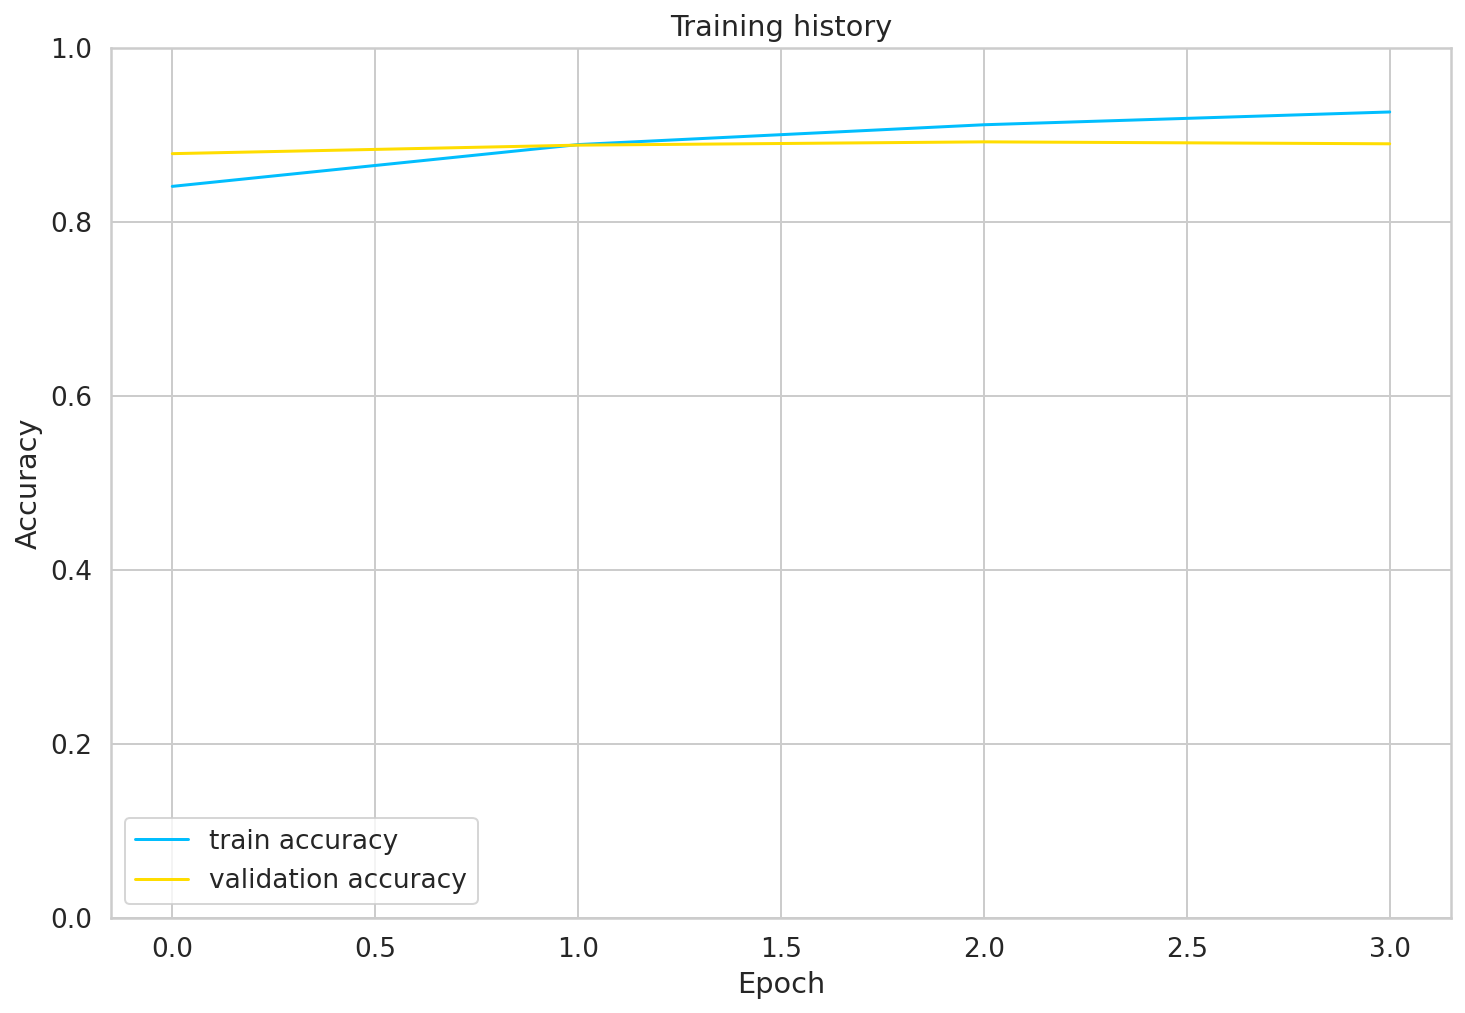

In [48]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

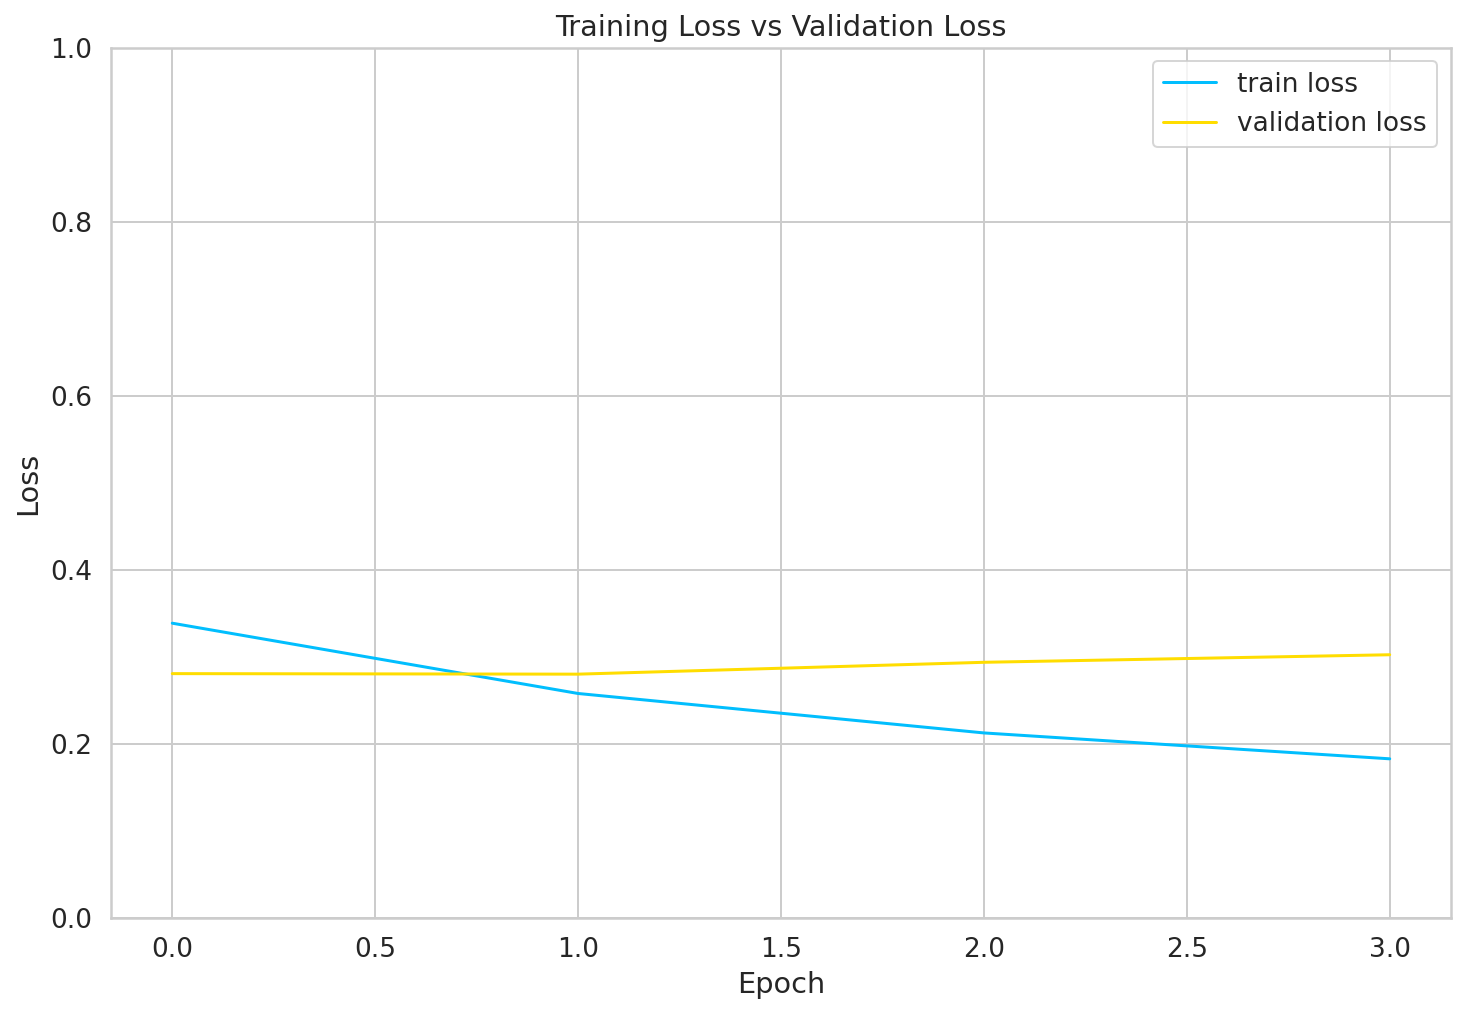

In [49]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Evaluation of the fine-tuned model

In [50]:
model.load_state_dict(torch.load('./xlnet_ptacek_run3.bin',map_location=torch.device('cpu')))

<All keys matched successfully>

In [51]:
model = model.to(device)

In [52]:
test_acc, test_loss = eval_model(
  model,
  test_data_loader,
  device,
  len(df_test)
)

print('Test Accuracy :', test_acc)
print('Test Loss :', test_loss)

Test Accuracy : 0.8831955922865014
Test Loss : 0.3029123136450437


In [55]:
def get_predictions(model, data_loader):
    model = model.eval()
    
    tweet_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["tweets"]
            input_ids = d["input_ids"].reshape(-1,128).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)

            loss = outputs[0]
            logits = outputs[1]
            
            _, preds = torch.max(outputs[1], dim=1)

            probs = F.softmax(outputs[1], dim=1)

            tweet_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return tweet_texts, predictions, prediction_probs, real_values

In [56]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [57]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           1       0.91      0.94      0.92      2948
           0       0.78      0.70      0.74       907

    accuracy                           0.88      3855
   macro avg       0.84      0.82      0.83      3855
weighted avg       0.88      0.88      0.88      3855



### Custom prediction function on raw text

In [60]:
def predict_sentiment(text):
    tweets = text

    encoded_review = tokenizer.encode_plus(
    tweets,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=False,
    return_attention_mask=True,
    return_tensors='pt',
    )

    input_ids = pad_sequences(encoded_review['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
    input_ids = input_ids.astype(dtype = 'int64')
    input_ids = torch.tensor(input_ids) 

    attention_mask = pad_sequences(encoded_review['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
    attention_mask = attention_mask.astype(dtype = 'int64')
    attention_mask = torch.tensor(attention_mask) 

    input_ids = input_ids.reshape(1,128).to(device)
    attention_mask = attention_mask.to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    outputs = outputs[0][0].cpu().detach()

    probs = F.softmax(outputs, dim=-1).cpu().detach().numpy().tolist()
    _, prediction = torch.max(outputs, dim =-1)

    print("Non Sarcasm Score ", probs[1])
    print("Sarcasm score:", probs[0])
    print(f'tweet text: {tweets}')
    print(f'Sentiment  : {class_names[prediction]}')

In [61]:
text = "Nice perfume. How long did you marinate in it?"
predict_sentiment(text)

Non Sarcasm Score  0.003047539386898279
Sarcasm score: 0.9969524145126343
tweet text: Nice perfume. How long did you marinate in it?
Sentiment  : 1


In [62]:
text = "i want to look like a 12 year old girl mixed with a retired body builder 💁 dreams  disgusting” 😂 😂 😂 😂 😂 iloveyou"
predict_sentiment(text)

Non Sarcasm Score  0.9859796166419983
Sarcasm score: 0.014020386151969433
tweet text: i want to look like a 12 year old girl mixed with a retired body builder 💁 dreams  disgusting” 😂 😂 😂 😂 😂 iloveyou
Sentiment  : 0
